# Fashion Mnist (Apple Silicon)

Requirements
* Matplotlib
* Numpy
* Tensorflow
* Tensorflow Datasets

In [158]:
import math

from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

Check for GPU devices

In [159]:
print(tf.__version__)

2.9.0


In [160]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Retrieve Fashion Mnist dataset by using tensorflow_datasets and display its metadata

In [161]:
data, metadata = tfds.load("fashion_mnist", as_supervised=True, with_info=True)
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='/Users/ebravo/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      au

Define variables to store training data and test data

In [162]:
training_data = data["train"]
test_data = data["test"]

Define a variable for data label

In [163]:
class_names = metadata.features["label"].names
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Create a normalizer function to normalize data, this function the images from 0-255 to 0-1

In [164]:
def normalizer(images: tf.Tensor, labels: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """Normalize images by scaling pixel intensity values from 0 to 255 to 0 to 1.

    :param images: A tensor of shape (batch_size, height, width, channels) representing the images to be normalized.
    :type images: tensor
    :param labels: A tensor of shape (batch_size, num_classes) representing the labels corresponding to the images.
    :type labels: tensor
    :return: A tuple of the normalized images and the labels
    :rtype: tuple
    """
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

Normalize train and test data and save them in cache

In [165]:
training_data = training_data.map(normalizer)
test_data = test_data.map(normalizer)

training_data = training_data.cache()
test_data = test_data.cache()

Show an image from test data

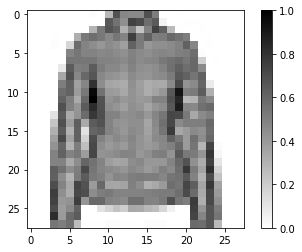

In [166]:
for image, label in test_data.take(1):
    break
image = image.numpy().reshape((28, 28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Show the classes in training data

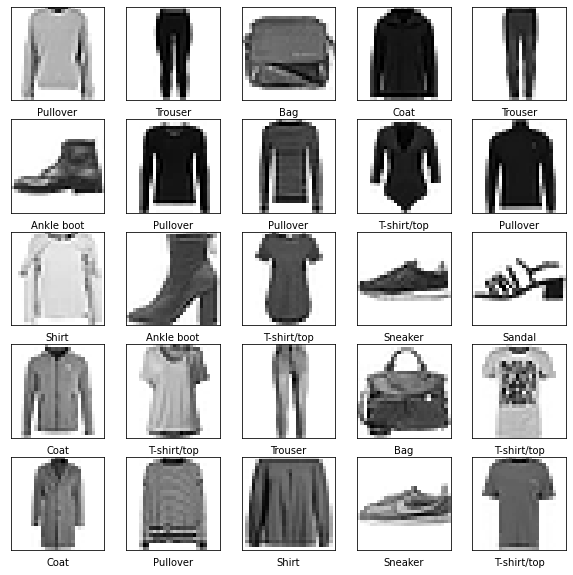

In [167]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(training_data.take(25)):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [168]:
len(class_names[label])

11

Define the neuron with 4 layers, 1 for flatten and 3 for dense with activation ReLu and Softmax

In [169]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
                             tf.keras.layers.Dense(50, activation=tf.nn.relu),
                             tf.keras.layers.Dense(50, activation=tf.nn.relu),
                             tf.keras.layers.Dense(11, activation=tf.nn.softmax)])
model.output_shape

(None, 11)

Compile the model

In [170]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

Display the number of elements in training data and test data groups

In [171]:
example_num_training = metadata.splits["train"].num_examples
example_num_test = metadata.splits["test"].num_examples
print(example_num_training)
print(example_num_test)

60000
10000


Setting up training data and test data before training

In [172]:
BATCH_SIZE = 32

training_data = (training_data
                 .repeat()
                 .shuffle(example_num_training)
                 .batch(BATCH_SIZE))
test_data = test_data.batch(BATCH_SIZE)

Start training by using GPU

In [173]:
with tf.device("/GPU:0"):
    history = model.fit(training_data,
                        epochs=15,
                        steps_per_epoch=math.ceil(example_num_training / BATCH_SIZE))

Epoch 1/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5180 - accuracy: 0.8137
Epoch 2/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3857 - accuracy: 0.8604
Epoch 3/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3461 - accuracy: 0.8744
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3270 - accuracy: 0.8799
Epoch 5/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3168 - accuracy: 0.8831
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2968 - accuracy: 0.8899
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2892 - accuracy: 0.8932
Epoch 8/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2757 - accuracy: 0.8979
Epoch 9/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2664 - accuracy: 0.9000
Epoch 10/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.26

Display the loss magnitude respect with each epoch

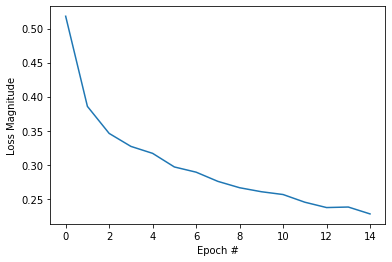

In [174]:
plt.xlabel("Epoch #")
plt.ylabel("Loss Magnitude")
plt.plot(history.history["loss"])

Evaluate the performance of a pre-trained model by plotting the results of the predictions against the true test labels.

1/1 [==============================] - 0s 42ms/step


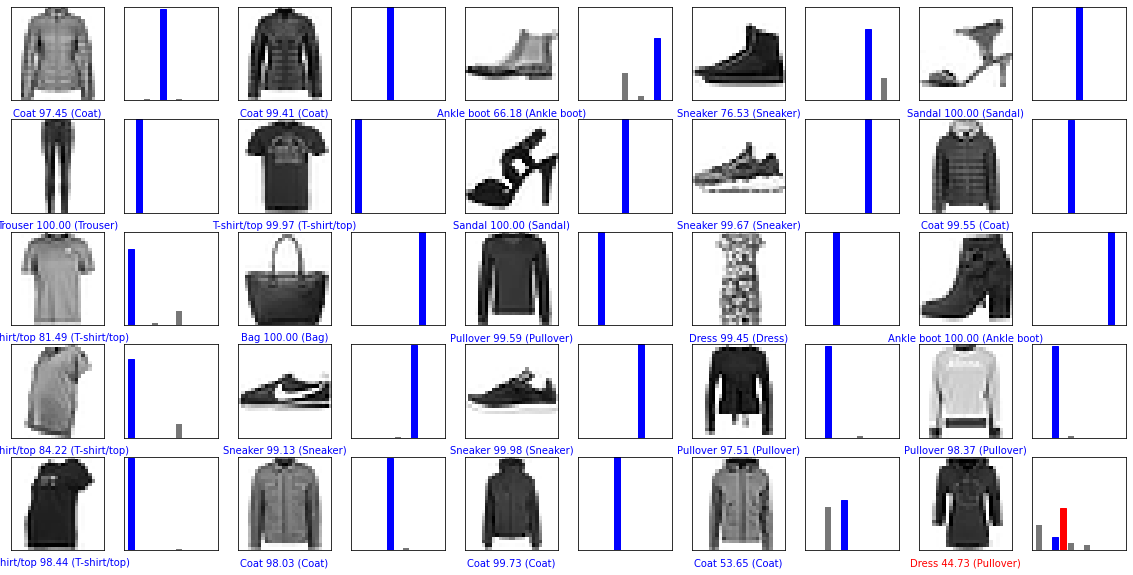

In [175]:
for test_images, test_labels in test_data.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

def plot_image(i, predictions_array: np.ndarray, real_labels: np.ndarray, images: np.ndarray) -> None:
    """
    Plot the image with the predicted and actual label.

    :param i: index of the prediction in the predictions_array and real_labels list
    :type i: np.ndarray
    :param predictions_array: List of predictions, where each prediction is a list of floats representing the model's 
                              predicted probabilities for each class.
    :type predictions_array: np.ndarray
    :param real_labels: List of actual labels.
    :type real_labels: np.ndarray
    :param images: List of images, where each image is represented as a numpy array.
    :type images: np.ndarray
    """
    prediction_array = predictions_array[i]
    real_label = real_labels[i]
    image = images[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image[..., 0], cmap=plt.cm.binary)

    prediction_label = np.argmax(prediction_array)

    # Assign colors for predictions or errors
    # Blue if prediction is True
    # Red if prediction is False
    if prediction_label == real_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(f"{class_names[prediction_label]} "
               f"{100 * np.max(prediction_array):.2f} "
               f"({class_names[real_label]})",
               color=color)

def plot_array_value(i, predictions_array: np.ndarray, real_labels: np.ndarray, output_shape: tuple) -> None:
    """
    This function is used to plot an array value, it receives an index "i" 
    which is used to access the values of the predictions array and the real labels
    and an output_shape variable that is used to set the range of the plot.
    It uses matplotlib to create the plot and set the color of the bars according
    to the result of the prediction.
    
    :param i: index that will be used to access the values of the predictions array and the real labels.
    :type i: int
    :param predictions_array: array of predictions
    :type predictions_array: np.ndarray
    :param real_labels: array of real labels
    :type real_labels: np.ndarray
    :param output_shape: shape of the output of the model
    :type output_shape: tuple
    """
    prediction_array = predictions_array[i]
    real_label = real_labels[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plot = plt.bar(range(output_shape), prediction_array, color="#777777")
    plt.ylim([0, 1])
    prediction_label = np.argmax(prediction_array)

    plot[prediction_label].set_color("red")
    plot[real_label].set_color("blue")

rows = 5
columns = 5
images_number = rows * columns
plt.figure(figsize=(2 * 2 * columns, 2 * rows))
for i in range(images_number):
    plt.subplot(rows, 2 * columns, 2 * i + 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(rows, 2 * columns, 2 * i + 2)
    plot_array_value(i, predictions, test_labels, model.output_shape[1])